In [ ]:
!pip install torch lerobot

In [ ]:
!pip install lerobot.data

In [ ]:
!pip install decord

## Training

In [12]:
# Add parent directory to path to import train module
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from train import train

print("\nStarting training process...")
print("Note: We'll use a public dataset for training as our sample is too small")

# Create a temporary directory for training output
train_output_dir = Path('model_output')

print(f"Training output will be saved to: {train_output_dir}")

train(output_dir=str(train_output_dir), dataset_id="ISdept/piper_arm")

Using device: mps

Starting training process...
Note: We'll use a public dataset for training as our sample is too small
Training output will be saved to: model_output


Fetching 45 files: 100%|██████████| 45/45 [00:08<00:00,  5.18it/s]


input_features: {'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>, shape=(7,)), 'observation.images.gripper': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640)), 'observation.images.rgb': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640)), 'observation.images.depth': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(1, 400, 640))}
output_features: {'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>, shape=(7,))}


ValueError: `observation.images.depth` does not match `observation.images.gripper`, but we expect all image shapes to match.

## Prepare dataset

In [1]:
# Import necessary modules
import sys
from pathlib import Path
import json
import re
import traceback

# Add the src directory to the path so we can import prepare_dataset
from data_processing.prepare_dataset import process_session, create_tasks_parquet, create_episodes_parquet_index, update_total_frames_from_episodes, compute_and_save_dataset_stats
from data_processing.episode_data import EpisodeData, CameraData

# --- CONFIGURATION ---
ROOT_FOLDER = Path("data/piper_training_data/")  # Root folder containing episode subfolders
OUTPUT_FOLDER = Path("output/")  # Output folder for processed dataset
REPO_ID = "ISDept/piper_arm"  # Your desired Hugging Face repo ID
# ---------------------

def find_episode_folders(root_folder):
    """Find all episode folders with naming convention episode1, episode2, etc."""
    episode_folders = []
    pattern = re.compile(r'^episode(\d+)$', re.IGNORECASE)
    
    for item in root_folder.iterdir():
        if item.is_dir():
            match = pattern.match(item.name)
            if match:
                episode_folders.append((item, int(match.group(1))))
    
    # Sort by episode number
    episode_folders.sort(key=lambda x: x[1])
    return episode_folders

def find_json_and_videos(episode_folder):
    """Find JSON file and video files in the episode folder."""
    json_files = list(episode_folder.glob("*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON file found in {episode_folder}")
    if len(json_files) > 1:
        print(f"Warning: Multiple JSON files found in {episode_folder}, using {json_files[0]}")
    
    json_path = json_files[0]
    
    # Find video files (assuming common video extensions)
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    video_files = []
    for ext in video_extensions:
        video_files.extend(episode_folder.glob(f"*{ext}"))
    
    return json_path, video_files

def get_camera_name_from_video_path(video_path):
    """Determine camera name based on video filename content."""
    filename = video_path.stem.lower()
    if 'rgb' in filename:
        return 'rgb'
    elif 'depth' in filename:
        return 'depth'
    elif 'gripper' in filename:
        return 'gripper'
    else:
        # Fallback: use the last part of filename after underscore
        return video_path.stem.split('_')[-1]
      
def process_episode_folder(episode_folder, episode_idx, global_index_offset, last_frames_to_chop):
    """Process a single episode folder."""
    json_path, video_files = find_json_and_videos(episode_folder)
    
    # Create CameraData objects from video files
    cameras_list = []
    for video_path in video_files:
        # Extract camera name from filename (you might want to customize this logic)
        camera_name = get_camera_name_from_video_path(video_path)
        cameras_list.append(CameraData(video_path=str(video_path), camera=camera_name))
    
    episode_data = EpisodeData(
        joint_data_json_path=str(json_path), 
        episode_index=episode_idx, 
        fps=10, 
        global_index_offset=global_index_offset, 
        cameras=cameras_list,
        folder = episode_folder,
        task_description = "Pick up the cube and place it into the container."
    )
    
    # Process the first episode differently to create initial files
    is_first_episode = (episode_idx == 1)
    num_of_frames = process_session(episode_data, OUTPUT_FOLDER, is_first_episode, last_frames_to_chop)
    episode_data.num_of_frames = num_of_frames
    return episode_data

def main():
    # Find all episode folders
    episode_folders = find_episode_folders(ROOT_FOLDER)
    
    if not episode_folders:
        print(f"No episode folders found in {ROOT_FOLDER}")
        return
    
    print(f"Found {len(episode_folders)} episode folders")
    
    last_frames_to_chop = 10
    global_index_offset = 0
    all_episodes_data = []
    
    
    # Process each episode folder
    for episode_folder, episode_idx in episode_folders:
                
        try:
            episode_data = process_episode_folder(episode_folder, episode_idx, global_index_offset, last_frames_to_chop)
            all_episodes_data.append(episode_data)
            
            # Update global index offset for the next episode
            global_index_offset += episode_data.num_of_frames
            #global_index_offset -= last_frames_to_chop
            
            
        except Exception as e:
            print(f"Error processing episode {episode_idx}: {e}")
            traceback.print_exc()
            continue
    
    # Create final output files after processing all episodes
    if all_episodes_data:
        # Only create tasks parquet for the first episode
        create_tasks_parquet(OUTPUT_FOLDER, 'pick_and_place')
        
        # Create episodes parquet index for all episodes
        for _, episode_idx in episode_folders:
            print('Handling index for episode:', episode_idx)
            create_episodes_parquet_index(OUTPUT_FOLDER, episode_idx)
        
        update_total_frames_from_episodes(OUTPUT_FOLDER)
        
        compute_and_save_dataset_stats(OUTPUT_FOLDER)
        
    else:
        print("No episodes were successfully processed")

if __name__ == "__main__":
    main()


/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])
/opt/anaconda3/envs/for_lerobot/lib/python3.10/site-packages/lerobot/datasets/compute_stats.py:154: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(batch[:, i], bins=self._bin_edges[i])


In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import HfApi
import os


!hf upload \
  'ISDept/piper_arm' \
  /Users/eddyma/DEV/Github/lerobot-piper/src/output \
  --repo-type dataset

## Inference

### Webcam inference

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

!python webcam_inference.py

### Video Inference

In [1]:
!python video_inference.py


Video LeRobot Inference Demo
Using device: mps
Loading model...
Loading model from: ISdept/piper_arm
Loading dataset metadata...
Fetching 45 files: 100%|██████████████████████| 45/45 [00:00<00:00, 2795.33it/s]
Creating policy configuration...
Force downloading model...
Initializing policy...
Policy config image features: {'observation.images.gripper': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640)), 'observation.images.rgb': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 400, 640)), 'observation.images.depth': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(1, 400, 640))}
Policy config crop_shape: None
Policy config use_group_norm: False
Policy config pretrained_backbone_weights: ResNet18_Weights.IMAGENET1K_V1
The output feature {'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>, shape=(7,))}
Loading preprocessors...
The dataset statistics have been loaded successfully for preprocessing.
Model loaded successfully!

MODEL LOADED 

In [2]:
!python extract_joint_positions.py

Extracted 162 frames of joint positions
Saved to temp/data_20251128_095915_gt.json
Extracted 143 actions from inference results
Saved to temp/inference_actions.json


## Visualize

Extracted 162 frames of joint positions
Saved to temp/data_20251128_095915_gt.json
Extracted 143 actions from inference results
Saved to temp/inference_actions.json
Frames plotted: 143 (from index 0 to 142)


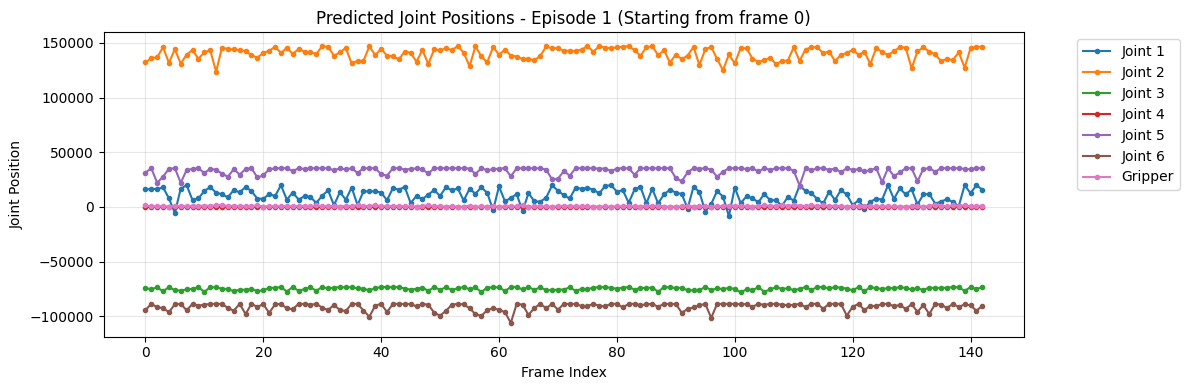

Frames plotted: 203 (from index 0 to 202)


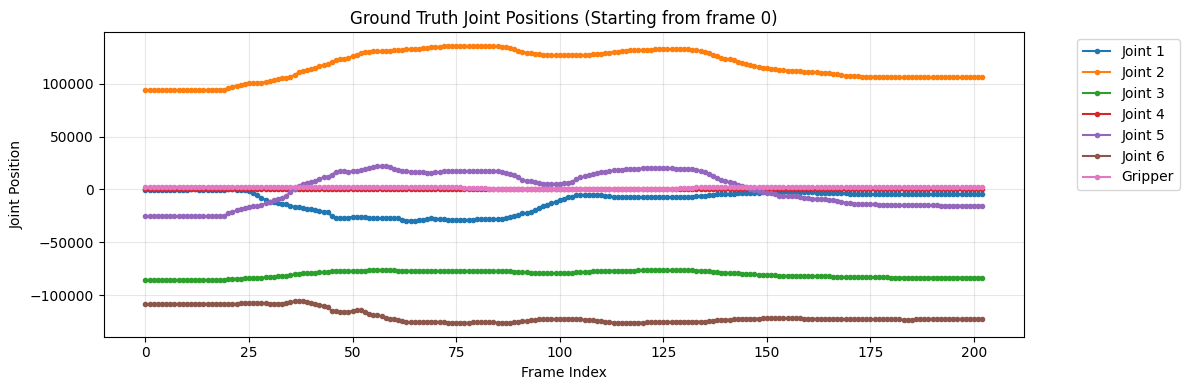

In [ ]:
!python extract_joint_positions.py

import json
import matplotlib.pyplot as plt
import numpy as np

def plot_joint_positions(json_file_path, title, start_frame_index=0):
    """
    Plots joint positions from a JSON file, starting from a specified frame index.
    Handles both inference results format and joint positions format.

    Parameters:
    json_file_path (str): Path to the JSON file.
    title (str): Title for the plot.
    start_frame_index (int): The frame index from which to start plotting. Defaults to 0 (the beginning).
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Check if this is inference results format (list of objects with 'result' key)
    # or joint positions format (list of arrays)
    if isinstance(data, list) and len(data) > 0:
        # This is joint positions format (list of arrays)
        # For this format, we'll just plot all data starting from start_frame_index
        if start_frame_index >= len(data):
            print(f"No data found starting from frame index {start_frame_index}.")
            return
        
        # Extract joint positions from start_frame_index onward
        filtered_data = data[start_frame_index:]
        frame_indices = list(range(start_frame_index, start_frame_index + len(filtered_data)))
        print(f"Frames plotted: {len(frame_indices)} (from index {min(frame_indices)} to {max(frame_indices)})")
        
        # Initialize lists for each joint
        joints = [[] for _ in range(7)]  # 6 joints + 1 gripper
        
        # Extract joint positions for each frame in the filtered data
        for action in filtered_data:
            for i in range(7):  # 6 joints + 1 gripper
                joints[i].append(action[i])

    
    # Create the plot
    plt.figure(figsize=(12, 4)) # Slightly larger figure for clarity
    
    # Joint names
    joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Gripper']
    
    # Plot each joint with a different color
    for i in range(7):
        plt.plot(frame_indices, joints[i], label=joint_names[i], marker='o', markersize=3, linewidth=1.5)
    
    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel('Joint Position')
    plt.title(f"{title} (Starting from frame {start_frame_index})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_joint_positions('temp/inference_actions.json', 'Predicted Joint Positions - Episode 1')
plot_joint_positions('temp/data_20251128_095915_gt.json', 'Ground Truth Joint Positions')


In [ ]:
from pathlib import Path
from lerobot.policies.diffusion.modeling_diffusion import DiffusionPolicy
output_directory = Path("outputs/eval/example_pusht_diffusion")
# Comment out the old pretrained model path
 # pretrained_policy_path = "lerobot/diffusion_pusht"
# Use your newly trained model path instead
pretrained_policy_path = Path("outputs/train/example_pusht_diffusion")
policy = DiffusionPolicy.from_pretrained("ISdept/piper_arm")

print(policy.config)

In [ ]:
# Updated plotting functionality using the new plotting utility
import sys
from pathlib import Path
sys.path.append(str(Path().resolve()))

from plotting_utils import plot_joint_positions

# Plot the data using the improved function that handles both file formats
plot_joint_positions('temp/inference_actions.json', 'Predicted Joint Positions - Episode 1')
plot_joint_positions('temp/metadata_20251113_080958_gt.json', 'Ground Truth Joint Positions')

In [ ]:
!python inspect_local_parquet.py

In [ ]:
!lerobot-train \
  --dataset.repo_id=ISdept/piper_arm \
  --policy.type=act \
  --output_dir=outputs/train/output \
  --job_name=pick_and_place \
  --policy.device=cuda \
  --policy.repo_id=ISdept/piper_arm \
  --wandb.enable=false

In [ ]:
!lerobot-eval \
  --policy.repo_id="ISdept/piper_arm" \
  --policy.type="diffusion" \
  --policy.device="mps" \
  --env.type="aloha" \
  --eval.n_episodes=10 \
  --output_dir="outputs/inference/piper_arm_eval" \
  --job_name="piper_arm_diffusion_eval"